<a href="https://colab.research.google.com/github/whoami-Lory271/NN-project-memorizing-transformers/blob/main/NN_project_Antonelli_DeSantis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installations and imports

In [1]:
!pip install pytorch_transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 KB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 29.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 9.9 MB/s eta 0:00:00


In [2]:
from pytorch_transformers import BertTokenizer
from pytorch_transformers import BertModel

In [3]:
!pip install torchdata --quiet
!pip install torchmetrics --quiet
!pip install torchtext --quiet
!pip install -U spacy --quiet
!python -m spacy download en_core_web_sm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 517.2/517.2 KB 4.0 MB/s eta 0:00:00


In [4]:
import torch
from torch import nn as nn
import numpy as np
from torch.nn import functional as F
from math import sqrt
import matplotlib.pyplot as plt
from torch.autograd import Variable
from pathlib import Path
from filelock import FileLock
import random
import tqdm
import gzip
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pickle as pkl
import torchtext
import torch
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
import spacy
from typing import Iterable, List
from torchtext.datasets import WikiText2
from torchmetrics.text.perplexity import Perplexity
from torchtext.vocab import build_vocab_from_iterator

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Dataset

In [6]:
# constants

NUM_BATCHES = int(1e5)
BATCH_SIZE = 16
SEQ_LEN = 512
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS

LEARNING_RATE = 1e-3 #2e-4 prima era così
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 20
GENERATE_EVERY  = 500
GENERATE_LENGTH = 512
CHECKPOINT = 10



In [7]:
train_iter, test_iter = WikiText2(split = ('train', 'test'))

In [ ]:
"""
from itertools import chain
data_iter = chain(train_iter, test_iter)
"""

In [ ]:
"""
token_transform = get_tokenizer('spacy', language = 'en_core_web_sm')

def yield_tokens(data) -> List[str]:
    for line in data:
        yield token_transform(line)

UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

vocabulary_ = build_vocab_from_iterator(yield_tokens(data_iter), min_freq = 1, specials = special_symbols, special_first = True)
vocabulary_.set_default_index(UNK_IDX)
vocabulary_.__len__()
"""

In [ ]:
"""
def preprocessing_(dataset):
  new_ds = torch.tensor([], dtype = torch.int32)
  for line in dataset:
    tokenized_line = torch.tensor([vocabulary_[token] for token in token_transform(line)])
    new_ds = torch.cat((new_ds, tokenized_line))
  return new_ds
"""

In [ ]:
"""
train_ds = preprocessing_(train_iter)
test_ds = preprocessing_(test_iter)
"""

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

100%|██████████| 231508/231508 [00:00<00:00, 261967.05B/s]


In [9]:
def preprocessing(dataset):
  new_ds = []
  for line in dataset:
    tokenized_line = tokenizer.tokenize(line)
    new_ds.append(tokenized_line)
  return new_ds

In [10]:
train_ds = preprocessing(train_iter)
test_ds = preprocessing(test_iter)

In [11]:
def convert_tokens_to_idxs(dataset):
  new_ds = torch.tensor([], dtype = torch.int32)
  for line in dataset:
    tokenized_line = torch.tensor(tokenizer.convert_tokens_to_ids(line))    
    new_ds = torch.cat((new_ds, tokenized_line))
  return new_ds

In [ ]:
train_ds = convert_tokens_to_idxs(train_ds)
test_ds = convert_tokens_to_idxs(test_ds)

In [13]:
train_ds.shape

torch.Size([2405592])

In [14]:
vocabulary = 30522

In [15]:
train_loader = DataLoader(train_ds, batch_size = 10000, shuffle = False, drop_last = True)
print(len(train_loader))
train_ds = torch.zeros((len(train_loader), 10000), dtype = torch.int32)
for i, document in enumerate(train_loader):
  train_ds[i] = document

240


In [16]:
test_loader = DataLoader(test_ds, batch_size = 10000, shuffle = False, drop_last = True)

test_ds = torch.zeros((len(test_loader), 10000), dtype = torch.int32)
for i, document in enumerate(test_loader):
  test_ds[i] = document

In [17]:
train_ds.shape

torch.Size([240, 10000])

In [18]:
test_ds.shape

torch.Size([30, 10000])

# KNN Memory

In [19]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.5 MB/s eta 0:00:00


In [20]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.4 MB/s eta 0:00:00


In [21]:
#import per la knn memory
import os
import math
import torch
import faiss
import numpy as np
from pathlib import Path
from functools import wraps

from contextlib import ExitStack, contextmanager

from einops import rearrange, pack, unpack

# multiprocessing

from joblib import Parallel, delayed, cpu_count

In [22]:
FAISS_INDEX_GPU_ID = int(os.getenv('FAISS_INDEX_GPU_ID', 0))

DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY = './.tmp/knn.memories'

# helper functions

def exists(val):
    return val is not None

def default(val, d):
    return val if exists(val) else d

def cast_list(val):
    return val if isinstance(val, list) else [val]

def all_el_unique(arr):
    return len(set(arr)) == len(arr)

@contextmanager
def multi_context(*cms):
    with ExitStack() as stack:
        yield [stack.enter_context(cls) for cls in cms]

def count_intersect(x, y):
    # returns an array that shows how many times an element in x is contained in tensor y
    return np.sum(rearrange(x, 'i -> i 1') == rearrange(y, 'j -> 1 j'), axis = -1)

def check_shape(tensor, pattern, **kwargs):
    return rearrange(tensor, f"{pattern} -> {pattern}", **kwargs)

# a wrapper around faiss IndexIVFFlat
# taking care of expiring old keys automagically

class KNN():
    def __init__(
        self,
        dim,
        max_num_entries,
        cap_num_entries = False,
        M = 15,
        keep_stats = False
    ):
        index = faiss.IndexHNSWFlat(dim, M, faiss.METRIC_INNER_PRODUCT)
        self.index = index
        self.max_num_entries = max_num_entries
        self.cap_num_entries = cap_num_entries
        self.is_trained = False
        self.keep_stats = keep_stats

        self.reset()

    def __del__(self):
        if hasattr(self, 'index'):
            del self.index

    def reset(self):
        self.ids = np.empty((0,), dtype = np.int32)

        if self.keep_stats:
            self.hits = np.empty((0,), dtype = np.int32)
            self.age_num_iterations = np.empty((0,), dtype = np.int32)
            self.ages_since_last_hit = np.empty((0,), dtype = np.int32)

        self.index.reset()
        self.is_trained = False

    def train(self, x):
        self.index.train(x)
        self.is_trained = True

    def add(self, x, ids):
        if not self.is_trained:
            self.train(x)

        self.ids = np.concatenate((ids, self.ids))

        if self.keep_stats:
            self.hits = np.concatenate((np.zeros_like(ids), self.hits))
            self.age_num_iterations = np.concatenate((np.zeros_like(ids), self.age_num_iterations))
            self.ages_since_last_hit = np.concatenate((np.zeros_like(ids), self.ages_since_last_hit))

        if self.cap_num_entries and len(self.ids) > self.max_num_entries:
            self.reset()

        return self.index.add(x)

    def search(
        self,
        x,
        topk,
        nprobe = 8,
        return_distances = False,
        increment_hits = False,
        increment_age = True
    ):
        if not self.is_trained:
            return np.full((x.shape[0], topk), -1)

        distances, indices = self.index.search(x, k = topk)

        if increment_hits and self.keep_stats:
            hits = count_intersect(self.ids, rearrange(indices, '... -> (...)'))
            self.hits += hits

            self.ages_since_last_hit += 1
            self.ages_since_last_hit *= (hits == 0)

        if increment_age and self.keep_stats:
            self.age_num_iterations += 1

        if return_distances:
            return indices, distances

        return indices

# KNN memory layer, where one can store key / value memories
# can automatically take care of a collection of faiss indices (across batch dimension)

class KNNMemory():
    def __init__(
        self,
        dim,
        max_memories = 16000,
        num_indices = 1,
        memmap_filename = './knn.memory.memmap',
        multiprocessing = True
    ):
        self.dim = dim
        self.num_indices = num_indices
        self.scoped_indices = list(range(num_indices))

        self.max_memories = max_memories
        self.shape = (num_indices, max_memories, 2, dim)
        self.db_offsets = np.zeros(num_indices, dtype = np.int32)

        self.db = np.memmap(memmap_filename, mode = 'w+', dtype = np.float32, shape = self.shape)
        self.knns = [KNN(dim = dim, max_num_entries = max_memories, cap_num_entries = True) for _ in range(num_indices)]
    
        self.n_jobs = cpu_count() if multiprocessing else 1

    def set_scoped_indices(self, indices):
        indices = list(indices)
        assert all_el_unique(indices), f'all scoped batch indices must be unique, received: {indices}'
        assert all([0 <= i < self.num_indices for i in indices]), f'each batch index must be between 0 and less than {self.num_indices}: received {indices}'
        self.scoped_indices = indices

    @contextmanager
    def at_batch_indices(self, indices):
        prev_indices = self.scoped_indices
        self.set_scoped_indices(indices)
        yield self
        self.set_scoped_indices(prev_indices)

    def clear(self, batch_indices = None):
        if not exists(batch_indices):
            batch_indices = list(range(self.num_indices))

        batch_indices = cast_list(batch_indices)

        for index in batch_indices:
            knn = self.knns[index]
            knn.reset()

        self.db_offsets[batch_indices] = 0

    def add(self, memories):
        check_shape(memories, 'b n kv d', d = self.dim, kv = 2, b = len(self.scoped_indices))

        memories = memories.detach().cpu().numpy()
        memories = memories[:, -self.max_memories:]
        num_memories = memories.shape[1]

        knn_insert_ids = np.arange(num_memories)

        keys = np.ascontiguousarray(memories[..., 0, :])
        knns = [self.knns[i] for i in self.scoped_indices]
        db_offsets = [self.db_offsets[i] for i in self.scoped_indices]

        # use joblib to insert new key / value memories into faiss index

        @delayed
        def knn_add(knn, key, db_offset):
            knn.add(key, ids = knn_insert_ids + db_offset)
            return knn

        updated_knns = Parallel(n_jobs = self.n_jobs)(knn_add(*args) for args in zip(knns, keys, db_offsets))
        for knn_idx, scoped_idx in enumerate(self.scoped_indices):
            self.knns[scoped_idx] = updated_knns[knn_idx]

        # add the new memories to the memmap "database"

        add_indices = (rearrange(np.arange(num_memories), 'j -> 1 j') + rearrange(self.db_offsets[list(self.scoped_indices)], 'i -> i 1')) % self.max_memories
        self.db[rearrange(np.array(self.scoped_indices), 'i -> i 1'), add_indices] = memories
        self.db.flush()

        self.db_offsets += num_memories

    def search(
        self,
        queries,
        topk,
        nprobe = 8,
        increment_hits = True,
        increment_age = True
    ):
        check_shape(queries, 'b ... d', d = self.dim, b = len(self.scoped_indices))
        queries, ps = pack([queries], 'b * d')

        device = queries.device
        queries = queries.detach().cpu().numpy()

        all_masks = []
        all_key_values = []

        knns = [self.knns[i] for i in self.scoped_indices]

        # parallelize faiss search

        @delayed
        def knn_search(knn, query):
            return knn.search(query, topk, nprobe, increment_hits = increment_hits, increment_age = increment_age)

        fetched_indices = Parallel(n_jobs = self.n_jobs)(knn_search(*args) for args in zip(knns, queries))

        # get all the memory key / values from memmap 'database'
        # todo - remove for loop below

        for batch_index, indices in zip(self.scoped_indices, fetched_indices):
            mask = indices !=  -1
            db_indices = np.where(mask, indices, 0)

            all_masks.append(torch.from_numpy(mask))

            key_values = self.db[batch_index, db_indices % self.max_memories]
            all_key_values.append(torch.from_numpy(key_values))

        all_masks = torch.stack(all_masks)
        all_key_values = torch.stack(all_key_values)
        all_key_values = all_key_values.masked_fill(~rearrange(all_masks, '... -> ... 1 1'), 0.)

        all_key_values, = unpack(all_key_values, ps, 'b * n kv d')
        all_masks, = unpack(all_masks, ps, 'b * n')

        return all_key_values.to(device), all_masks.to(device)

    def __del__(self):
        if hasattr(self, 'knns'):
            for knn in self.knns:
                del knn
        del self.db

# extends list with some extra methods for collections of KNN memories

class KNNMemoryList(list):
    def cleanup(self):
        for memory in self:
            del memory

    @classmethod
    def create_memories(
        self,
        *,
        batch_size,
        num_memory_layers,
        memories_directory = DEFAULT_KNN_MEMORY_MEMMAP_DIRECTORY
    ):
        memories_path = Path(memories_directory)
        memories_path.mkdir(exist_ok = True, parents = True)

        def inner(*args, **kwargs):
            return self([KNNMemory(*args, num_indices = batch_size, memmap_filename = str(memories_path / f'knn.memory.layer.{ind + 1}.memmap'), **kwargs) for ind in range(num_memory_layers)])
        return inner

    @contextmanager
    def at_batch_indices(
        self,
        indices
    ):
        knn_batch_indices_contexts = [memory.at_batch_indices(indices) for memory in self]
        with multi_context(*knn_batch_indices_contexts):
            yield

    def clear_memory(
        self,
        batch_indices = None,
        memory_indices = None
    ):
        memory_indices = default(memory_indices, tuple(range(len(self))))

        for memory_index in memory_indices:
            memory = self[memory_index]
            memory.clear(batch_indices)

# Memorizing transformers

In [23]:
def attention(query, key, value, sqrt_q, device, mask = None):
    t = torch.matmul(query, key.transpose(-2, -1))/sqrt_q
    if mask is not None:
      t = t.masked_fill_(mask == 0, -1e-9)
    return torch.matmul(F.softmax(t, dim = -1), value)

def KNNattention(query, key, value, sqrt_q, mask):
    t = torch.einsum('b h i q, b h i j q -> b h i j', query, key)/sqrt_q
    return torch.einsum('b h i j, b h i j q -> b h i q', F.softmax(t.masked_fill_(mask, -1e-9), dim = -1), value)

In [24]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d, h, batch_size):
    super(MultiHeadAttention, self).__init__()
    assert d % h == 0
    #assume q = v 
    self.q = d // h #single head dimension
    self.sqrt_q = sqrt(self.q)
    self.h = h
    self.batch_size = batch_size
    self.W_q = nn.Linear(d, d, bias = False) #stack of h matrices of dimension (d, q), one for each head
    self.W_k = nn.Linear(d, d, bias = False)
    self.W_v = nn.Linear(d, d, bias = False)
    self.W_o = nn.Linear(d, d, bias = False)

  def forward(self, x, mask = None):
    query = self.W_q(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    key = self.W_k(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    value = self.W_v(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
    #new_memories = torch.stack((key, value), dim = -2).detach()
    attention_value = attention(query, key, value, self.sqrt_q, mask)
    return self.W_o(attention_value.transpose(1, 2).contiguous().view(self.batch_size, -1, self.h*self.q))

In [25]:
class KNNAttention(nn.Module):
   def __init__(self, d, h, batch_size, num_retrieved_memories):
      super(KNNAttention, self).__init__()
      assert d % h == 0
      #assume q = v 
      self.q = d // h
      self.sqrt_q = sqrt(self.q)
      self.h = h
      self.W_q = nn.Linear(d, d, bias = False)
      self.W_k = nn.Linear(d, d, bias = False)
      self.W_v = nn.Linear(d, d, bias = False)
      self.W_o = nn.Linear(d, d, bias = False)
      self.b_g = nn.Parameter(torch.randn((h,))) #one for each head
      self.num_retrieved_memories = num_retrieved_memories
      self.batch_size = batch_size

   def forward(self, x, mask, knn_memory):
      # calculate local attention 
      query = self.W_q(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      key = self.W_k(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      value = self.W_v(x).view(self.batch_size, -1, self.h, self.q).transpose(1, 2)
      local_attention = attention(query, key, value, self.sqrt_q, mask)

      # calculate knn attention over memory
      query = F.normalize(query, dim = -1)
      key = F.normalize(key, dim = -1)
      mem_kv, mem_mask = knn_memory.search(query, self.num_retrieved_memories)
      mem_key, mem_value = mem_kv.unbind(dim = -2)
      knn_attention = KNNattention(query, mem_key, mem_value, self.sqrt_q, ~mem_mask)

      # memory to be stored
      new_kv_memories = torch.stack((key, value), dim = -2).view(self.batch_size, -1, 2, self.q).detach()

      # add to knn memory
      if new_kv_memories.numel() > 0:
        knn_memory.add(new_kv_memories)

      # combining local and memory
      g = torch.sigmoid(self.b_g)
      final_attention = torch.einsum('b h n q, h -> b h n q', knn_attention, g) + \
                        torch.einsum('b h n q, h -> b h n q', local_attention, (1 - g))
      
      return self.W_o(final_attention.transpose(1, 2).contiguous().view(self.batch_size, -1, self.h*self.q))

In [26]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=5000):
    super(PositionalEncoding, self).__init__()
    
    # Compute the positional encodings once in log space.
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2) *
                          -(math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)
      
  def forward(self, x):
    return x + Variable(self.pe[:, :x.size(1)], requires_grad=False)

In [27]:
class TransformerBlock(nn.Module):
  def __init__(self, d, h, batch_size, hidden_size, dropout, is_mem = False, num_retrieved_memories = 32):
    super(TransformerBlock, self).__init__()
    self.d = d
    self.h = h
    self.batch_size = batch_size
    self.attention = MultiHeadAttention(d, h, batch_size) if not is_mem else KNNAttention(d, h, batch_size, num_retrieved_memories)
    self.norm1 = nn.LayerNorm(d)
    self.dropout1 = nn.Dropout(dropout)
    self.norm2 = nn.LayerNorm(d)
    self.dropout2 = nn.Dropout(dropout)
    self.ff = nn.Sequential(nn.Linear(d, hidden_size, bias = True), 
                            nn.ReLU(),
                            nn.Dropout(dropout),
                            nn.Linear(hidden_size, d, bias = True))
  def forward(self, x, mask, knn_memory = None):
    if knn_memory is None:
      x = self.attention(x, mask)
    else:
      x = self.attention(x, mask, knn_memory)
    x = self.dropout1(x + self.norm1(x))
    x = x + self.ff(x)
    x = self.dropout2(self.norm2(x))
    return x

In [28]:
class DecoderBlock(nn.Module): #block of the classic transformer decoder (not used)
  def __init__(self, d, h, batch_size, hidden_size, dropout):
    super(DecoderBlock, self).__init__()
    self.attention = MultiHeadAttention(d, h, batch_size)
    self.norm = nn.LayerNorm(d)
    self.dropout = nn.Dropout(dropout)
    self.transformer_block = TransformerBlock(d, h, batch_size, hidden_size, dropout)

  def forward(self, x, mask):
    x = self.attention(x, mask)
    x = self.dropout(self.norm(x))
    return self.transformer_block(x)

In [41]:
class MemorizingTransformer(nn.Module):
    def __init__(
          self,
          num_tokens,
          d,
          heads = 8,
          depth = 4,
          knn_attn_idx = 2,
          attn_dropout = 0.,
          hidden_size = 1000,
          dropout = 0.3,
          max_knn_memories = 1000,
          num_retrieved_memories = 32,
          batch_size = 16,
          use_bert = True
      ):
          # asserts
          self.d = d if not use_bert else 768
          assert self.d % heads == 0
          assert knn_attn_idx < depth

          super(MemorizingTransformer, self).__init__()
          #self.token_emb = nn.Embedding(num_tokens, self.d) #without BERT
          self.token_emb = BertModel.from_pretrained('bert-base-uncased')
          self.positional_enc = PositionalEncoding(self.d, max_len = 5000)
          self.dim_head = self.d // heads
          
          self.heads = heads
          self.knn_attn_idx = knn_attn_idx
          self.depth = depth
          self.attn_dropout = attn_dropout
          self.hidden_size = hidden_size
          self.dropout = dropout
          self.max_knn_memories = max_knn_memories
          self.num_retrieved_memories = num_retrieved_memories
          self.batch_size = batch_size

          self.layers = nn.ModuleList([])
          for idx in range(depth):
            self.layers.append(
                TransformerBlock(self.d, heads, batch_size, hidden_size, dropout, is_mem = idx == self.knn_attn_idx)
            )

          self.to_out = nn.Linear(self.d, num_tokens)
    
    def create_mask(self, x):
      batch_size, seq_len = x.shape
      mask = torch.tril(torch.ones((seq_len, seq_len))).expand(
          batch_size, 1, seq_len, seq_len)
      return mask    
          
    def forward(self, x, knn_memory):
      mask = self.create_mask(x)
      #x = self.token_emb(x) #without BERT
      x = self.token_emb(x)[0] #with BERT
      x = self.positional_enc(x)

      for idx in range(self.depth):
          x= self.layers[idx](x, mask, knn_memory = knn_memory if idx == self.knn_attn_idx else None)

      return self.to_out(x).transpose(1, 2)

# Training

In [43]:
# constants

BATCH_SIZE = 4
SEQ_LEN = 256
SEGMENTS = 5
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS 
DIM_HEAD_BERT = 768 // HEADS #now it's 96 with bert -> 768/8

LEARNING_RATE = 2e-4
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 1
CHECKPOINT = 1

In [39]:
model = None
memory = None
data = None
train_loader_ = None
test_loader_ = None

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MemorizingTransformer(
    num_tokens = vocabulary,
    d = SEQ_LEN,
    heads = HEADS,
    batch_size = BATCH_SIZE,
    depth = 4,
    knn_attn_idx = 2,
    num_retrieved_memories = 32,
    use_bert = True #False if you want to try without BERT
).to(device)

memory = KNNMemory(
    dim = DIM_HEAD_BERT,       #substitute with DIM_HEAD if you want to try without BERT
    max_memories = 1000,       #maximum number of memories (old ones will be discarded after reaching maximum capacity)
    num_indices = BATCH_SIZE   #each batch keeps track of its own memories, expiring when it sees a new document
)

train_loader_ = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)
test_loader_ = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

In [ ]:
def print_string(a):
  seq = ""
  for word in a:
    for letter in word:
      seq += chr(letter)
    seq += " "
  return seq

In [46]:
# optimizer

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
loss = nn.CrossEntropyLoss()
epochs = 5
# training

perplexity_list = []

for e in range(epochs):
  for i, data in enumerate(tqdm.tqdm(train_loader_, desc = 'training')):
    model.train()

    train_loss = 0.

    num_seq = 10000 // (SEQ_LEN + 1)
    data = data.long().to(device)
    for j in range(num_seq):
      mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
      seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]
      out = model(
        seq,
        knn_memory = memory
      )
      loss_item = loss(out, labels)
      print(f'training loss: {loss_item}', flush = True)
      loss_item.backward() 
      torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
      optimizer.step()
      optimizer.zero_grad()
  data = None

  if e % EVAL_EVERY == 0:
    model.eval()

    with torch.no_grad():
      metric = Perplexity().to(device)
      for i, data in enumerate(tqdm.tqdm(test_loader_, desc = 'evaluation')):
        num_seq = 10000 // (SEQ_LEN + 1)
        data = data.long().to(device)

        for j in range(num_seq):
          mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
          seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]
          out = model(
            seq,
            knn_memory = memory
          )
          test_loss = loss(out, labels)
          metric(out.transpose(1, 2), labels)
          #print(f'test loss: {test_loss}', flush = True)

      perplexity = metric.compute()
      perplexity_list.append(perplexity.to("cpu").item())
      print(f'perplexity: {perplexity}', flush = True)

  data = None
  if e % CHECKPOINT == 0:
    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
    }, 'model_optimizer.pt')
    """
    #Lorenzo
    with open('/content/drive/MyDrive/Università/Magistrale/Secondo Anno/Neural Networks/project/perplexity_moreNN.npy', 'wb') as f:
      np.save(f, np.array(perplexity_list))
    """
    with open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:
      pkl.dump(perplexity_list, pklfile)

plt.plot(perplexity_list, label = "Memorizing Transformer Perplexity Plot")
plt.legend()
plt.show()

evaluation: 100%|██████████| 7/7 [05:17<00:00, 45.30s/it]

perplexity: 692.0040283203125



evaluation:   0%|          | 0/7 [00:17<?, ?it/s]


KeyboardInterrupt: ignored

# Transformer decoder training

In [ ]:
class TransformerDecoder(nn.Module): #decoder-only architecture of the transformer
  def __init__(
        self,
        num_tokens,
        d,
        heads = 8,
        depth = 4,
        hidden_size = 1000,
        dropout = 0.3,
        batch_size = 16,
        use_bert = True
    ):
      # asserts
      self.d = d if not use_bert else 768
      assert self.d % heads == 0
 
      super(TransformerDecoder, self).__init__()
      self.token_emb = nn.Embedding(num_tokens, self.d)
      self.positional_enc = PositionalEncoding(self.d, max_len = 5000)
      self.dim_head = self.d // heads
      self.heads = heads
      self.depth = depth
      self.hidden_size = hidden_size
      self.dropout = dropout
      self.batch_size = batch_size

      self.layers = nn.ModuleList([])
      for idx in range(depth):
          self.layers.append(
              TransformerBlock(d, heads, batch_size, hidden_size, dropout)
          )

      self.to_out = nn.Linear(d, num_tokens)
    
  def create_mask(self, x):
    batch_size, seq_len = x.shape
    mask = torch.tril(torch.ones((seq_len, seq_len))).expand(
        batch_size, 1, seq_len, seq_len
    )
    return mask 
          
  def forward(self, x):
    mask = self.create_mask(x)

    x = self.token_emb(x)
    x = self.positional_enc(x)

    for idx in range(self.depth):
        x= self.layers[idx](x, mask)

    return self.to_out(x).transpose(1, 2)

In [ ]:
# constants

BATCH_SIZE = 8
SEQ_LEN = 256
SEGMENTS = 5
HEADS = 8
DIM_HEAD = SEQ_LEN // HEADS
DIM_HEAD_BERT = 768 // HEADS
LEARNING_RATE = 2e-4
MAX_GRAD_CLIP_NORM = 0.5

EVAL_EVERY = 20
CHECKPOINT = 5

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tr_decoder = TransformerDecoder(
    num_tokens = vocabulary,
    d = SEQ_LEN,
    depth = 10,
    heads = HEADS,
    hidden_size = 5000,
    batch_size = BATCH_SIZE,
    use_bert = True
).to(device)

train_loader_ = DataLoader(train_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)
test_loader_ = DataLoader(test_ds, batch_size = BATCH_SIZE, shuffle = False, drop_last = True)

In [ ]:
# optimizer
optimizer = torch.optim.Adam(tr_decoder.parameters(), lr = LEARNING_RATE)
loss = nn.CrossEntropyLoss()
epochs = 5
# training

perplexity_tr_decoder = []

for e in range(epochs):
  for i, data in enumerate(tqdm.tqdm(train_loader_, desc = 'training')):
    tr_decoder.train()

    train_loss = 0.

    num_seq = 10000 // (SEQ_LEN + 1)
    data = data.long().to(device)
    for j in range(num_seq):
      mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
      seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]

      out = tr_decoder(seq)

      loss_item = loss(out, labels)
      print(f'training loss: {loss_item}', flush = True)
      loss_item.backward() 
      torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
      optimizer.step()
      optimizer.zero_grad()
  data = None
    

  if e % EVAL_EVERY == 0:
    tr_decoder.eval()

    with torch.no_grad():
      metric = Perplexity().to(device)
      for i, data in enumerate(tqdm.tqdm(test_loader_, desc = 'evaluation')):
        num_seq = 10000 // (SEQ_LEN + 1)
        data = data.long().to(device)

        for j in range(num_seq):
          mini_batch = data[:, j*(SEQ_LEN + 1):(j+1)*(SEQ_LEN + 1)]
          seq, labels = mini_batch[:, :-1], mini_batch[:, 1:]

          out = tr_decoder(seq)

          test_loss = loss(out, labels)
          metric(out.transpose(1, 2), labels)
          print(f'test loss: {test_loss}', flush = True)

      perplexity = metric.compute()
      perplexity_tr_decoder.append(perplexity.to("cpu").item())
      print(f'perplexity: {perplexity}', flush = True)

  data = None
  if e % CHECKPOINT == 0:
    torch.save({
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
    }, 'model_optimizer.pt')
    """
    #Lorenzo
    with open('/content/drive/MyDrive/Università/Magistrale/Secondo Anno/Neural Networks/project/perplexity_moreNN.npy', 'wb') as f:
      np.save(f, np.array(perplexity_list))
    """
    with open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:
      pkl.dump(perplexity_tr_decoder, pklfile)

plt.plot(perplexity_tr_decoder, label = "Transformer Decoder Perplexity Plot")
plt.legend()
plt.show()

In [ ]:
"""
perplexity_tr_decoder = []
with open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:
  perplexity_tr_decoder = pkl.load(pklfile)
  pklfile.close()
"""

"\nperplexity_tr_decoder = []\nwith open(f'drive/MyDrive/Colab Notebooks/perplexity_tr_decoder.pkl', 'rb') as pklfile:\n  perplexity_tr_decoder = pkl.load(pklfile)\n  pklfile.close()\n"

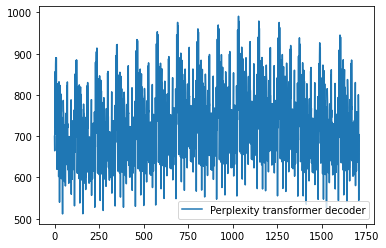

In [ ]:
plt.plot(perplexity_tr_decoder, label = 'Perplexity transformer decoder')
plt.legend()
plt.show()

zzz